<a href="https://colab.research.google.com/github/Shrusti23/EE258_neural-networks/blob/master/MNIST_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Importing necessary libraries
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import numpy as np
import pandas as pd

In [0]:
# For MNIST dataset, the classes are: 0,1,2,3,4,5,6,7,8,9
num_classes = 10

# Adding column names for dataframes
colnames = ['label']
for i in range(1, 785):
  colnames += ['pixel'+str(i)]

from google.colab import drive
drive.mount('/content/drive')

train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/mnist_train.csv', names = colnames, header=None)
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/mnist_test.csv', names = colnames, header=None)

# ResNet-20
depth = 20


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
test

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9996,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9997,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9998,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
train

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,147,252,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
59996,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
59997,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
59998,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
# TRAINING

# drop training label
labels = train['label'].values
train.drop('label', axis=1, inplace=True)


# reshape
images = train.values
images = np.array([np.reshape(i, (28, 28)) for i in images])
images = np.array([i.flatten() for i in images])

label_binarizer = LabelBinarizer() # to convert numerical variables to categorical variables for multi-class classification
labels = label_binarizer.fit_transform(labels)

# splitting
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=101)

# input image dimensions
input_shape = (28,28,1)

# normalizing training and test data
x_train = x_train.astype('object') / 255
x_test = x_test.astype('object') / 255

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

In [0]:
def learn_rate_schedule(epoch): # not really needed until higher epochs which I can't use yet
    """
    Learning schedule so learning rate decreases after 80, 120, 160, 180 epochs
    Arguments
        epoch: number of epochs
    Returns
        learn_rate: learning rate
    """

    learn_rate = 1e-3
    if epoch > 180:
        learn_rate *= 0.5e-3
    elif epoch > 160:
        learn_rate *= 1e-3
    elif epoch > 120:
        learn_rate *= 1e-2
    elif epoch > 80:
        learn_rate *= 1e-1

    print('Learning rate: ', learn_rate)

    return learn_rate

In [0]:
def resnet_layer(inputs,
                num_filters=14,
                kernel_size=3,
                strides=1,
                activation='relu',
                batch_normalization=True,
                conv_first=True):
    """
    2D convolution batch-normalization-activation stack builder
    Arguments
        inputs: input tensor from input image or prev layer
        num_filters: conv2D number of filters
        kernel_size: conv2D square kernel dimensions
        strides: conv2D square stride dimensions
        activation: activation name
        batch_normalization: to include batch_normalization or not
        conv_first: order of convolution
    Returns
        x: tensor as input to next layer
    """

    conv = Conv2D(num_filters,
                kernel_size=kernel_size,
                strides=strides,
                padding='same',
                kernel_initializer='he_normal',
                kernel_regularizer=l2(1e-4))

    x = inputs

    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)

    return x

In [0]:
def resnet_model(input_shape, depth, num_classes):
    """
    resnet model builder
    Arguments
        input_shape: shape of the input image tensor
        depth: number of core convolutional layers
        num_classes: number of classes
    Returns
        model: Keras model instance
    """

    num_filters = 14
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)

    # instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # for first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                            num_filters=num_filters,
                            strides=strides)
            y = resnet_layer(inputs=y,
                            num_filters=num_filters,
                            activation=None)
            if stack > 0 and res_block == 0:  # for first layer but not first stack
                # linear projection residual shortcut connection to match changed dims
                x = resnet_layer(inputs=x,
                                num_filters=num_filters,
                                kernel_size=1,
                                strides=strides,
                                activation=None,
                                batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # add classifier on top
    x = AveragePooling2D(pool_size=(2,2))(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # instantiate model
    model = Model(inputs=inputs, outputs=outputs)

    return model



In [0]:
def model_runner(batch_size, epochs):
    """
    Runs the model
    Arguments
        batch_size: the batch size
        epoch: number of epochs
    """

    model = resnet_model(input_shape=input_shape, depth=depth, num_classes=10)

    model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=learn_rate_schedule(0)),
              metrics=['accuracy'])

    model.summary()

    learn_rate_scheduler = LearningRateScheduler(learn_rate_schedule)

    mo= model.fit(x_train,
                    y_train,
                    validation_data=(x_test, y_test),
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    callbacks=[learn_rate_scheduler])
    

    y_pred = model.predict(test_images)
    test_accuracy = accuracy_score(test_labels, y_pred.round())
    print('test accuracy', test_accuracy)
    
    score = model.evaluate(x_test, y_test, verbose=0)

    print("Accuracy on test set: ",score[1])
    print(mo.history['val_loss'])
    print(mo.history['val_accuracy'])
    print(mo.history['loss'])
    print(mo.history['accuracy'])

    import matplotlib.pyplot as plt
    plt.plot(mo.history['accuracy']) 
    plt.plot(mo.history['val_accuracy'])
    plt.title('model accuracy') 
    plt.ylabel('accuracy') 
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(mo.history['loss'])
    plt.plot(mo.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    

In [0]:
# TESTING

    # drop test label
    test_labels = test['label'].values
    test.drop('label', axis=1, inplace=True)

    # reshape
    test_images = test.values
    test_images = np.array([np.reshape(i, (28, 28)) for i in test_images])
    test_images = np.array([i.flatten() for i in test_images])

    test_images = test_images.astype('object') / 255

    test_labels = label_binarizer.fit_transform(test_labels)

    test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

Learning rate:  0.001
Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_136 (Conv2D)             (None, 28, 28, 14)   140         input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_118 (BatchN (None, 28, 28, 14)   56          conv2d_136[0][0]                 
__________________________________________________________________________________________________
activation_118 (Activation)     (None, 28, 28, 14)   0           batch_normalization_118[0][0]    
_____________________________________________________________________

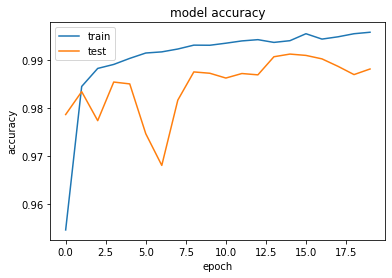

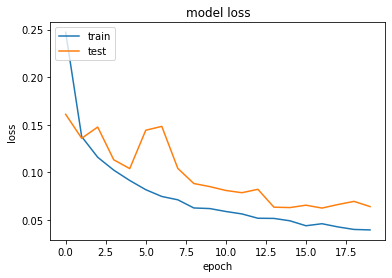

In [0]:


if __name__ == '__main__':

   mo=model_runner(batch_size=32, epochs=20)
    
   


In [0]:
! pip install virtualenv

!pip install --upgrade wandb

import wandb

wandb.init(sync_tensorboard=True)


Requirement already up-to-date: wandb in /usr/local/lib/python3.6/dist-packages (0.8.31)


W&B Run: https://app.wandb.ai/shrusti/uncategorized/runs/3bu1de8u